In [17]:
from binascii import a2b_qp
import json
from nis import match
from MemoryEntry import MemoryEntry
from MemoryBank import MemoryBank
from typing import List
import argparse
from MemoryBank import MemoryBank
from tqdm import tqdm
from consistency import check_consistency, Implication
from MemoryEntry import MemoryEntry
import utils
import json
import torch
import sklearn
import matplotlib.pyplot as plt
from models import *
import tensorflow as tf
import numpy as np
from tqdm import tqdm

import torch



In [18]:
def evaluate_nli_constraint_knowledge(config, contra_test=False):
    constraints = json.load(open("data/constraints_v2.json"))
    constraints = [Implication(c) for c in constraints["links"]]
    bank = MemoryBank(config)
    it_results_entailment = []
    it_results_neutral = []
    it_results_contradiction = []
    entity_results_entailment = []
    entity_results_neutral = []
    entity_results_contradiction = []
    for constraint in tqdm(constraints):
        a = MemoryEntry(entity='poodle', relation=constraint.source, answer=constraint.ans[0])
        b = MemoryEntry(entity='poodle', relation=constraint.target, answer=constraint.ans[1])
        if contra_test:
            if b.answer == 'yes':
                b.answer = 'no'
            elif b.answer == 'no':
                b.answer = 'yes'
        it_result = bank.get_relation(a.get_nli_statement(), b.get_nli_statement())
        it_results_entailment += [it_result[0]]
        it_results_neutral += [it_result[1]]
        it_results_contradiction += [it_result[2]]
        e_result =bank.get_relation(a.get_declarative_statement(), b.get_declarative_statement())
        entity_results_entailment += [e_result[0]]
        entity_results_neutral += [e_result[1]]
        entity_results_contradiction += [e_result[2]]
    
    all_results = np.vstack((it_results_entailment, it_results_neutral, it_results_contradiction))
    decision = np.argmax(all_results, axis=0)
    print(f"Entailment: {np.sum(decision == 0)}, Neutral: {np.sum(decision == 1)}, Contradiction: {np.sum(decision == 2)}")
    return it_results_entailment, it_results_neutral, it_results_contradiction, entity_results_entailment, entity_results_neutral, entity_results_contradiction

In [19]:
orig = evaluate_nli_constraint_knowledge(baseline_config)

100%|██████████| 4060/4060 [03:11<00:00, 21.23it/s]


Entailment: 1716, Neutral: 2163, Contradiction: 181


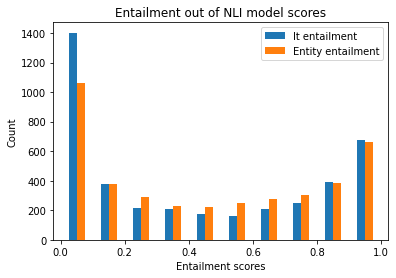

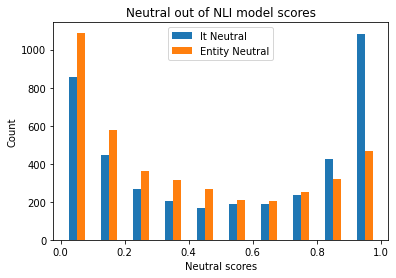

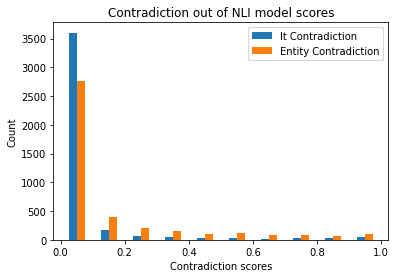

In [20]:
def plot(it_results_entailment, it_results_neutral, it_results_contradiction, entity_results_entailment, entity_results_neutral, entity_results_contradiction):
    plt.hist([it_results_entailment, entity_results_entailment], rwidth=0.5, range=(0, 1), label=["It entailment", "Entity entailment"])
    plt.legend()
    plt.xlabel("Entailment scores")
    plt.ylabel("Count")
    plt.title("Entailment out of NLI model scores")
    plt.show()
    plt.hist([it_results_neutral, entity_results_neutral], rwidth=0.5, range=(0, 1), label=["It Neutral", "Entity Neutral"])
    plt.legend()
    plt.xlabel("Neutral scores")
    plt.ylabel("Count")
    plt.title("Neutral out of NLI model scores")
    plt.show()
    plt.hist([it_results_contradiction, entity_results_contradiction], rwidth=0.5, range=(0, 1), label=["It Contradiction", "Entity Contradiction"])
    plt.legend()
    plt.xlabel("Contradiction scores")
    plt.ylabel("Count")
    plt.title("Contradiction out of NLI model scores")
    plt.show()
plot(*orig)

What if we flip the hypothesis and look for contradictions?

100%|██████████| 4060/4060 [03:13<00:00, 20.99it/s]


Entailment: 520, Neutral: 1518, Contradiction: 2022


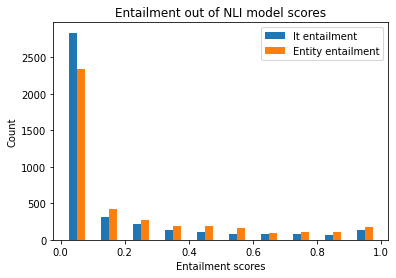

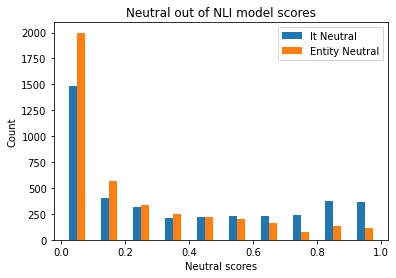

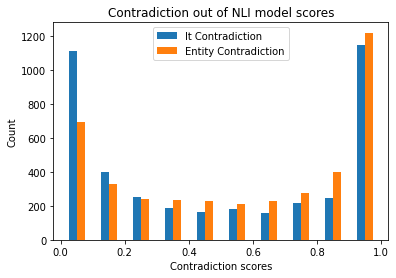

In [21]:
orig_contra = evaluate_nli_constraint_knowledge(baseline_config, contra_test=True)
plot(*orig_contra)

In [22]:
roberta = evaluate_nli_constraint_knowledge(roberta_flip_config)

100%|██████████| 4060/4060 [03:11<00:00, 21.19it/s]

Entailment: 280, Neutral: 2183, Contradiction: 1597


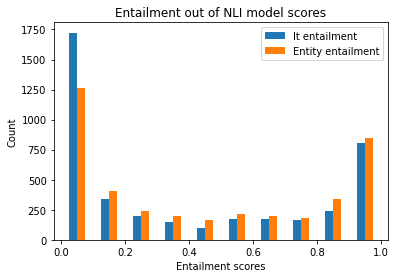

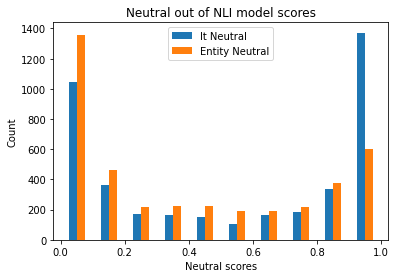

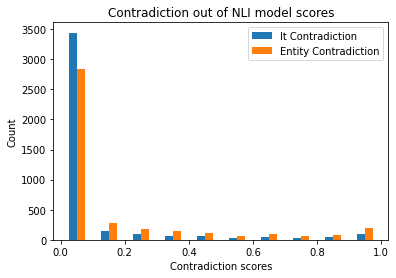

In [23]:
# note that entail and contradiction are flipped
plot(roberta[2], roberta[1], roberta[0], roberta[5], roberta[4], roberta[3])


In [24]:
roberta_contra = evaluate_nli_constraint_knowledge(roberta_flip_config, contra_test=True)

100%|██████████| 4060/4060 [03:12<00:00, 21.05it/s]


Entailment: 3132, Neutral: 771, Contradiction: 157


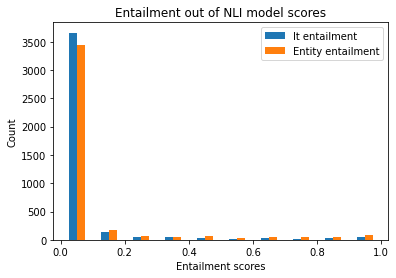

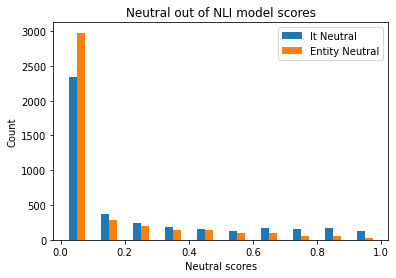

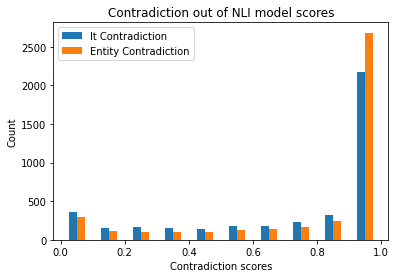

In [25]:
# note that entail and contradiction are flipped
plot(roberta_contra[2], roberta_contra[1], roberta_contra[0], roberta_contra[5], roberta_contra[4], roberta_contra[3])
